### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from neuropy.utils import signal_process
from scipy.ndimage import gaussian_filter1d
from tqdm.notebook import tqdm
from scipy import stats
import subjects
import pandas as pd

### View spectrogram (whitened or regular)

In [ ]:
from neuropy.utils.signal_process import FourierSg
from hfuncs import whiten_signal
import scipy.signal as sg

sessions = subjects.NsdOld().ratB1_2022_06_24

for sub, sess in enumerate(sessions):
    signal = sess.eegfile.get_signal(192, 0, 10)
    # signal = whiten_signal(signal)
    spect = FourierSg(signal, window=1, overlap=0.1, norm_sig=False)

    # spect = sg.spectrogram(signal.traces[0], fs=1250, nperseg=1250)

In [ ]:
_, ax = plt.subplots()

ax.imshow(
    spect[2],
    aspect="auto",
    vmax=70000,
    origin="lower",
    extent=[0, duration, spect[0][0], spect[0][-1]],
)
ax.set_ylim([0, 20])

In [ ]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()

ax.imshow(
    spect.traces,
    aspect="auto",
    vmax=50,
    cmap="jet",
    origin="lower",
    extent=[
        spect.time[0] / 3600,
        spect.time[-1] / 3600,
        spect.freqs[0],
        spect.freqs[-1],
    ],
)
# ax.set_ylim(top=100)

In [ ]:
from neuropy.plotting import Fig

emg = spect.get_band_power(300, 600)
theta = spect.theta
delta = spect.delta

rem = theta / (delta * emg)

fig = Fig(7, 6)
maze = sess.paradigm["maze"].flatten()
ax = fig.subplot(fig.gs[1:4])
ax.plot((spect.time - maze[1]) / 3600, delta, "k")
ax.set_ylim(top=400)
ax.set_xlim(left=0, right=11.70)

fig.savefig(subjects.figpath_sd / "swa_old")

In [ ]:
_, ax = plt.subplots()
ax.plot(sess.position.time, sess.position.z)
ax.plot(sess.maze1.time, sess.maze1.x)
ax.plot(sess.maze2.time, sess.maze2.x)

In [ ]:
%matplotlib widget
from neuropy.plotting import plot_signal_heatmap
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.imshow(
    spect.traces,
    aspect="auto",
    vmax=0.004,
    cmap="jet",
    origin="lower",
    extent=[spect.time[0], spect.time[-1], spect.freqs[0], spect.freqs[-1]],
)


### Plot SWA activity across sesssion

In [ ]:
sessions = subjects.nsd.ratUday2

for s, sess in enumerate(sessions):
    chan = sess.best_channels.slow_wave
    signal = sess.eegfile.get_signal(chan)
    spect = signal_process.FourierSg(signal, window=2, overlap=1, norm_sig=True)

In [ ]:
swa = spect.get_band_power(1, 4)

swa_dict = {
    "swa": swa,
    "t_start": spect.t_start,
    "sampling_rate": spect.sampling_rate,
    "window": 2,
    "overlap": 1,
    "channel": chan,
}

np.save(sess.filePrefix.with_suffix(".SWA_activity_for_Kourosh"), swa_dict)

In [ ]:
from scipy.ndimage import gaussian_filter1d

_, ax = plt.subplots()

swa = gaussian_filter1d(spect.get_band_power(1, 4), 3)
ax.plot(swa)

### Pooled detection hippocampal slow waves
- Using best slow wave channel that is most bimodal in slow wave power

In [ ]:
from tqdm.notebook import tqdm
from neuropy.analyses.oscillations import detect_hpc_delta_wave_epochs

sessions = subjects.ripple_sess()

for sub, sess in enumerate(tqdm(sessions)):
    noisy_epochs = sess.brainstates["NOISE"]
    channel = sess.best_channels.slow_wave
    signal = sess.eegfile.get_signal(int(channel))
    epochs = detect_hpc_delta_wave_epochs(
        signal, freq_band=(0.5, 4), ignore_epochs=noisy_epochs
    )
    epochs.save(sess.filePrefix.with_suffix(".delta_wave"))

### View in Neuroscope Delta waves 

In [ ]:
from neuropy.core import Epoch

sess = subjects.nsd.ratUday2[0]
swa = sess.sw.to_dataframe()
starts, stops = swa.peaktime.values, swa.stop.values
epochs = Epoch.from_array(starts, stops)
sess.recinfo.write_epochs(epochs, ".swa")

### Old: Fig1A related:Averaged slow oscillation power during NSD and SD POST

In [3]:
from neuropy.core import Signal
from scipy.ndimage import gaussian_filter1d

# sessions = subjects.nsd.ratSday2 + subjects.sd.ratSday3
smooth = lambda x: gaussian_filter1d(x, sigma=60 / 4)
sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4
# sessions = subjects.ripple_sess()
swa, swa_time, brainstates = [], [], []
for sess in sessions:
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    t_start = pre[0]
    # t_stop = t_start + 8*3600
    t_stop = post[0] + 8 * 3600

    signal = sess.eegfile.get_signal(191, t_start=t_start, t_stop=t_stop)
    trace = signal.traces[0].astype("int16")
    for e in sess.artifact.as_array():
        indx = (signal.time >= e[0]) & (signal.time <= e[1])
        trace[indx] = 0

    signal = Signal(trace[np.newaxis, :], sampling_rate=1250, t_start=signal.t_start)
    spect = signal_process.FourierSg(signal, window=4, overlap=0, norm_sig=False)
    delta = smooth(spect.delta * (0.95 * 1e-3) ** 2)
    delta /= delta.mean()

    post_indx = (spect.time >= post[0]) & (spect.time <= t_stop)
    swa.append(delta[post_indx])
    swa_time.append(spect.time[post_indx])

    states = sess.brainstates.time_slice(t_start, t_stop).shift(-t_start)
    brainstates.append(states.to_dataframe())

# subjects.GroupData().save(dict(swa=swa, swa_time=swa_time), "swa_examples")

AttributeError: 'FourierSg' object has no attribute 'delta'

In [ ]:
from neuropy.plotting import plot_epochs, plot_hypnogram
from neuropy.core import Epoch

_, axs = plt.subplots(
    3, 2, sharey="row", sharex="col", gridspec_kw=dict(height_ratios=[1, 1, 4])
)

for i in range(2):
    time = swa_time[i]

    # plot_hypnogram(
    #     Epoch(brainstates[i]),
    #     ax=axs[0, i],
    #     # labels_order=["nrem", "rem", "quiet", "active"],
    #     # colors=subjects.colors_sleep_old,
    # )

    # plot_epochs(
    #     brainstates[i],
    #     ax=axs[1, i],
    #     labels_order=["nrem", "rem", "quiet", "active"],
    #     colors=subjects.colors_sleep_old,
    # )
    # axs[1,i].axis('off')

    axs[2, i].plot(time / 3600, swa[i])
    # axs[1,i].set_xlim(left=time[0])
    x_ticks = axs[1, i].get_xticks()
    new_xticks = (x_ticks - swa_time[i][0]) / 3600
    # axs[1,i].set_xticks(x_ticks,new_xticks.round(2))

### Old: Average SWA during POST NSD vs SD (sd_figure1)

In [4]:
from scipy.ndimage import gaussian_filter1d

sessions = subjects.ripple_sess()

smooth = lambda x: gaussian_filter1d(x, sigma=5 * 60 / 36)

sw_df = []
for sess in tqdm(sessions):
    post = sess.paradigm["post"].flatten()
    t_start, t_stop = post[0] + 0 * 3600, post[0] + 5 * 3600

    chan = sess.ripple.metadata["channels"][3]
    signal = sess.eegfile.get_signal(chan, t_start=t_start, t_stop=t_stop)
    spect = signal_process.FourierSg(signal, window=36, overlap=0, norm_sig=False)
    delta = spect.delta * (0.95 * 1e-3) ** 2
    delta = smooth(delta)
    # delta_5 = np.lib.stride_tricks(delta,window=5)
    df = pd.DataFrame(
        dict(
            swa=delta,
            # zt=(spect.time - t_start) / 3600,
            zt=np.arange(0, 5, 0.01),
            name=sess.name,
            grp=sess.tag,
        )
    )
    sw_df.append(df)

sw_df = pd.concat(sw_df, ignore_index=True)
# subjects.GroupData().save(sw_df, "swa_examples")

  0%|          | 0/16 [00:00<?, ?it/s]

AttributeError: 'FourierSg' object has no attribute 'delta'

In [ ]:
_, axs = plt.subplots()

sns.lineplot(data=sw_df, x="zt", y="swa", hue="grp", ci=None)

### Old: SWA power as percentage above baseline(MAZE) during NSD and SD POST

In [ ]:
# sessions = subjects.nsd.ratSday2 + subjects.sd.ratSday3
# sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4
sessions = subjects.nsd.ratNday2 + subjects.sd.ratNday1

In [ ]:
swa, swa_time, brainstates = [], [], []
for sess in sessions:
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()

    spect_kw = dict(window=2 * 60, overlap=60, norm_sig=False)

    signal = sess.eegfile.get_signal(113, *maze)
    baseline = signal_process.FourierSg(signal, **spect_kw).get_band_power(0.5, 4).mean()

    post = [post[0], post[0] + 8 * 3600]
    states = sess.brainstates.time_slice(*post).shift(-post[0])
    signal = sess.eegfile.get_signal(113, *post)
    spect = signal_process.FourierSg(signal, **spect_kw)

    swa.append(spect.get_band_power(0.5, 4) / baseline)
    swa_time.append(spect.time - post[0])
    brainstates.append(states.to_dataframe())

# subjects.GroupData().save(
#     dict(swa=swa, swa_time=swa_time, brainstates=brainstates), "swa_examples"
# )

In [ ]:
from neuropy.plotting import plot_epochs, plot_hypnogram
from neuropy.core import Epoch

_, axs = plt.subplots(
    3, 2, sharey="row", sharex="col", gridspec_kw=dict(height_ratios=[1, 1, 4])
)

for i in range(2):
    time = swa_time[i]

    plot_hypnogram(
        Epoch(brainstates[i]),
        ax=axs[0, i],
        # labels_order=["nrem", "rem", "quiet", "active"],
        # colors=subjects.colors_sleep_old,
    )

    plot_epochs(
        brainstates[i],
        ax=axs[1, i],
        labels_order=["nrem", "rem", "quiet", "active"],
        colors=subjects.colors_sleep_old,
    )
    axs[1, i].axis("off")

    axs[2, i].plot(time, swa[i])
    # axs[1,i].set_xlim(left=time[0])
    x_ticks = axs[1, i].get_xticks()
    new_xticks = (x_ticks - swa_time[i][0]) / 3600
    # axs[1,i].set_xticks(x_ticks,new_xticks.round(2))

### Best slow wave channels based on bimodality of slope

In [ ]:
sessions = subjects.sd.ratUday1
from neuropy.utils.signal_process import FourierSg
from hfuncs import whiten_signal
import scipy.signal as sg
from numpy.polynomial import polynomial
from scipy.ndimage import gaussian_filter1d

for sub, sess in enumerate(sessions):
    # channels = [19,25,2,1,93,87,189,183]
    # channels = sess.recinfo.channel_groups[4][::4]
    channels = sess.ripple.metadata["channels"]
    slopes = []
    for chan in channels:
        signal = sess.eegfile.get_signal(chan)
        # spect = FourierSg(signal,window=60,overlap=10)
        f, t, spect = sg.spectrogram(
            signal.traces[0], fs=1250, nperseg=10 * 1250, noverlap=9 * 1250, axis=-1
        )
        spect = gaussian_filter1d(spect, sigma=4, axis=0)

        indices = (f > 4) & (f < 90)
        f = np.log10(f[indices])
        spect = np.log10(spect[indices, :])

        invalid_col = ~np.isfinite(spect).any(axis=0)
        linfit = np.polyfit(f, spect[:, ~invalid_col], deg=1)
        slopes.append(linfit[0])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from dip import diptst
import statsmodels.api as sm
from scipy.signal import find_peaks
from dip import diptst

# bins = np.linspace(1,3,100)
_, axs = plt.subplots(3, 4)
axs = axs.reshape(-1)

bins = np.arange(1, 3.5, 0.02)
cmap = mpl.cm.get_cmap("jet")
metric = []
for i, slp in enumerate(slopes):
    hist_slopes = np.histogram(np.abs(slp), bins=bins)[0]
    # kde = sm.nonparametric.KDEUnivariate(gaussian_filter1d(np.abs(slp),sigma=2))
    # kde.fit()
    hist_slopes = gaussian_filter1d(hist_slopes, sigma=2)
    pval = diptst(hist_slopes, is_hist=True)[1]
    print(pval)
    metric.append(diptst(hist_slopes, is_hist=True)[1])

    # peaks_ind = find_peaks(kde.density)[0]

    # if len(peaks_ind)>1:
    #     peaks_ind = peaks_ind[:2]
    #     peaks_loc = kde.support[peaks_ind]
    #     h1,h2 = kde.density[peaks_ind]

    #     between_peak = kde.density[peaks_ind[0]:peaks_ind[1]]
    #     dip_ind = find_peaks(-1 * between_peak)[0]+ peaks_ind[0]
    #     dip_loc = kde.support[dip_ind]
    #     dip_height = kde.density[dip_ind]

    #     param1 =  np.abs(h1-h2)/(h1+h2)
    #     param2 = np.diff(peaks_loc)

    #     metric.append([param1,param2])
    #     ax.plot(kde.support,kde.density,label=channels[i])

    # else:

    #     ax.plot(kde.support,kde.density,label=channels[i])
    # if i==1:
    axs[i].plot(bins[:-1], hist_slopes, color=cmap(i / len(slopes)))
#     ax.axvline(peaks_loc[0])
#     ax.axvline(peaks_loc[1])
#     ax.axvline(dip_loc)

# ax.legend()

In [ ]:
metric1 = np.asarray(metric)
_, ax = plt.subplots()
# plt.plot(metric1[:,0],metric1[:,1],'.')
plt.plot(metric, ".")

In [ ]:
from neuropy.plotting import plot_signal_heatmap
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.imshow(
    spect,
    aspect="auto",
    vmax=400,
    cmap="jet",
    origin="lower",
    extent=[t[0], t[-1], f[0], f[-1]],
)

### CCG between Interneurons and hpc slow waves

In [ ]:
import numpy as np
import subjects

sessions = subjects.sd.pf_sess
# channels = [23,103,183,191,127,55]
channels = [13, 45, 32, 57, 7, 83]

In [ ]:
from neuropy.utils.ccg import correlograms
from neuropy.core import Epoch

ccgs_all = []
avg_sw = []
for sub, sess in enumerate(sessions):
    sw = sess.sw.starts
    sw_id = np.ones(len(sw))
    neurons = sess.neurons.get_neuron_type("inter")

    trace = sess.eegfile.get_signal(channels[sub]).traces[0]
    frames = np.concatenate(
        [np.arange(e - 500, e + 500) for e in (sw * 1250).astype("int")]
    )
    avg_sw_sub = np.mean(trace[frames].reshape(len(sw), -1), axis=0, keepdims=True)
    avg_sw.append(np.tile(avg_sw_sub, (neurons.n_neurons, 1)))

    def _get_ccg(spikes):
        clus = np.concatenate([sw_id, 2 * np.ones(len(spikes))]).astype("int")
        trains = np.concatenate([sw, spikes])
        sort_ind = np.argsort(trains)
        ccgs = correlograms(
            trains[sort_ind],
            clus[sort_ind],
            bin_size=0.010,
            window_size=0.8,
            sample_rate=30000,
        )
        return ccgs[0, 1, :]

    ccgs_all.append(np.asarray([_get_ccg(_) for _ in neurons.spiketrains]))

ccgs_all = np.vstack(ccgs_all)
avg_sw = np.vstack(avg_sw)

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats

_, axs = plt.subplots(13, 5, sharex=True)
axs = axs.reshape(-1)
t = np.linspace(-405, 405, ccgs_all.shape[1] + 1)
t2 = np.linspace(-400, 400, avg_sw.shape[1])
for i, ax in enumerate(axs):
    ax.stairs(ccgs_all[i] / np.mean(ccgs_all[i]), t, fill=True)
    ax.plot(t2, avg_sw[i] / np.sum(avg_sw[i]) + 0.5, "r")

### Delta amplitude - Ripple probability scatter plot

In [ ]:
sessions = subjects.pf_sess()
from hfuncs import get_ccg

delta_rpl_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()

    if sess.tag == "NSD":
        period = [post[0], post[0] + 2 * 3600]

    if sess.tag == "SD":
        period = [post[0] + 5 * 3600, post[0] + 7 * 3600]

    if sess.delta_wave is not None:
        sw = sess.delta_wave.time_slice(*period)
        rpls = sess.ripple.time_slice(*period)

        peak_amp = sw.to_dataframe().peak_amp_zsc
        end_amp = sw.to_dataframe().stop_amp_zsc
        delta_amp = np.abs(peak_amp) + np.abs(end_amp)

        sw_t = sw.to_dataframe().peak_time
        rpl_t = rpls.to_dataframe().peak_time

        quantiles = pd.qcut(delta_amp, q=5, labels=False)

        for q in range(5):
            idx = (quantiles == q).values
            n_delta = np.count_nonzero(idx)
            t, ccg = get_ccg(sw_t[idx], rpl_t, 0.001, 0.8)

            prob = ccg[(t > -0.1) & (t < 0.1)].sum() / n_delta
            mean_amp = np.mean(delta_amp[idx])

            df = pd.DataFrame(
                dict(delta_amp=[mean_amp], prob=[prob], grp=sess.tag, session=sub)
            )
            delta_rpl_df.append(df)

delta_rpl_df = pd.concat(delta_rpl_df, ignore_index=True)

In [ ]:
# _,ax = plt.subplots()
# sns.lineplot(data=delta_rpl_df,x='time',y='prob',hue='grp',ci='sd',ax=ax)

sns.lmplot(
    data=delta_rpl_df,
    x="delta_amp",
    y="prob",
    hue="grp",
    palette=subjects.colors_sd(1),
    ci=None,
)
# sns.boxplot(data=delta_rpl_df,x='delta_amp',y='prob',hue='grp',ax=ax)
# ax.axvline(0,color='k')

### Delta - Ripple probability SD vs NSD in 2.5 hour blocks

In [ ]:
from hfuncs import get_ccg

sessions = subjects.ripple_sess()

delta_rpl_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()

    if sess.tag == "NSD":
        period = [post[0], post[0] + 2 * 3600]

    if sess.tag == "SD":
        period = [post[0] + 5 * 3600, post[0] + 7 * 3600]

    if sess.delta_wave is not None:
        sw = sess.delta_wave.time_slice(*period)
        rpls = sess.ripple.time_slice(*period)

        peak_amp = sw.to_dataframe().peak_amp_zsc
        end_amp = sw.to_dataframe().stop_amp_zsc
        delta_amp = np.abs(peak_amp) + np.abs(end_amp)

        sw_t = sw.to_dataframe().peak_time
        rpl_t = rpls.to_dataframe().peak_time

        t, ccg = get_ccg(sw_t, rpl_t, 0.001, 0.8)
        ccg = gaussian_filter1d(ccg, sigma=2)

        df = pd.DataFrame(dict(time=t, prob=ccg / len(sw_t), grp=sess.tag, session=sub))

        delta_rpl_df.append(df)

delta_rpl_df = pd.concat(delta_rpl_df, ignore_index=True)

In [ ]:
fig = plotting.Fig(5, 3)

ax = fig.subplot(fig.gs[1])
sns.lineplot(
    data=delta_rpl_df, x="time", y="prob", hue="grp", ci=None, ax=ax, color="#e000d9"
)
ax.axvline(0, color="k")
# ax.axvline(-0.1,color='r',ls='--')
# ax.axvline(0.1,color='r',ls='--')
ax.axvspan(-0.1, 0.1, color="#d0cdcd", alpha=0.3)


# sns.boxplot(data=delta_rpl_df,x='delta_amp',y='prob',hue='grp',ax=ax)

### Slow wave power in the first hour of recovery sleep 

In [2]:
from neuropy.utils.signal_process import filter_sig, FourierSg
from scipy.ndimage import gaussian_filter1d
from neuropy.core import Epoch

# sessions = subjects.sd.ripple_sess
sessions = subjects.sd.ratKday1 + subjects.sd.ratNday1 + subjects.sd.ratRday2

spect_list: list[FourierSg] = []
states_list: list[Epoch] = []
for s, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    nrem = (
        sess.brainstates["NREM"].time_slice(post[0], post[1]).duration_slice(min_dur=120)
    )
    nrem_onset = nrem.flatten()[0] - 1000

    # period = [nrem_onset, nrem_onset + 3600]
    period = [post[0] + 5 * 3600, post[0] + 6 * 3600]
    chan = sess.best_channels.slow_wave
    lfp = sess.eegfile.get_signal(chan, *period)
    srate = sess.eegfile.sampling_rate

    spect = FourierSg(lfp, window=4, overlap=1).freq_slice(1, 10)
    states = sess.brainstates.time_slice(period[0], period[1])

    spect_list.append(spect)
    states_list.append(states)

    # swa = spect.freq_slice(0.5, 4).traces.sum(axis=0)
    # spect_srate = spect.sampling_rate
    # swa = gaussian_filter1d(swa, sigma=4 * spect_srate)
    # swa = stats.zscore(swa)
    # time = spect.time - post[0]

    # df = pd.DataFrame(dict(time=time / 3600, swa=swa, session=s, grp=sess.tag))
    # swa_df.append(df)

# swa_df = pd.concat(swa_df, ignore_index=True)

NameError: name 'spect_list' is not defined

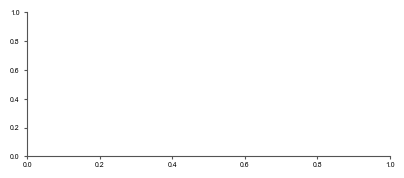

In [23]:
fig = subjects.SdFig().fig_supp(height_ratios=[1, 4, 1, 4, 1, 4, 1, 4],
                                width_ratios=[1, 1, 1, 1, 0.25, 0.75, 1, 1])
vmax_use = 0.5
combine_wake = False
state_bin_size = 30  # seconds
for i in range(len(sessions)):
    ax = fig.subplot(fig.gs[i * 2 + 1, :4])
    sxx = spect_list[i]

    swa = sxx.freq_slice(1, 4).traces.sum(axis=0)
    spect_srate = sxx.sampling_rate
    swa = gaussian_filter1d(swa, sigma=4 * sxx.sampling_rate)
    swa = stats.zscore(swa)
    time = (sxx.time - sxx.time[0]) / 3600 + 5.05

    splot = ax.imshow(
        sxx.traces,
        aspect="auto",
        origin="lower",
        extent=[5.05, 6.05, 1, 10],
        cmap="magma",
        vmax=vmax_use,
    )
    ax2 = ax.twinx()
    ax2.plot(time, swa, color="w", lw=1)
    # plt.colorbar(splot, ax=ax)

    post = sessions[i].paradigm["post"].flatten()
    period = [post[0] + 5.05 * 3600, post[0] + 6.05 * 3600]

    ax3 = fig.subplot(fig.gs[i * 2, :4])
    states = sessions[i].brainstates

    # Combined AW/QW code
    # wk_states = states.label_slice(["AW", "QW"]).set_labels("WK").merge_neighbors()
    # slp_states = states.label_slice(["NREM", "REM"])
    # all_states = slp_states + wk_states

    # Split QW/AW code
    # Change resolution
    if state_bin_size > 1:
        # states = states.resample_labeled_epochs(state_bin_size, t_start=time[0], t_stop=time[-1], merge_neighbors=True)
        states = states.resample_labeled_epochs(state_bin_size, t_start=period[0], t_stop=period[1], merge_neighbors=True)
        bin_append = f"_statebin{state_bin_size}"
        
    if combine_wake: # Combine wake states
        wk_states = states.label_slice(["AW", "QW"]).set_labels("WK").merge_neighbors()
        labels_order = ["NREM", "REM", "WK"]
    else: # Keep states split
        wk_states = states.label_slice(["AW", "QW"])
        labels_order = ["NREM", "REM", "QW", "AW"]
    slp_states = states.label_slice(["NREM", "REM"])
    all_states = slp_states + wk_states

    # # NRK attempted bugfix
    # all_states_df = all_states.to_dataframe()
    # all_states_df["label"] = deepcopy(pd.Categorical(all_states_df["label"], labels_order))
    # all_states = Epoch(epochs=all_states_df)
    plotting.plot_epochs(
        epochs=all_states, ax=ax3, labels_order=labels_order, colors="k"
    )
    ax3.set_xlim(period)
    # ax3.set_xticks(post_t, zt_time)
    # ax3.set_axis_off()
    # df = swa_df[swa_df.session == i]
    # x = df["time"].values
    # y = df["swa"].values

    # ax = axs[i]
    # ax.plot(x, y)

# sns.lineplot(data=swa_df, x="time", y="swa", units="session", estimator=None)

fig.savefig(subjects.figpath_sd / "sd_slow_oscillation_recovery_sleep_vmax0_5", format="svg")

### Whiten above before plotting to emphasize theta

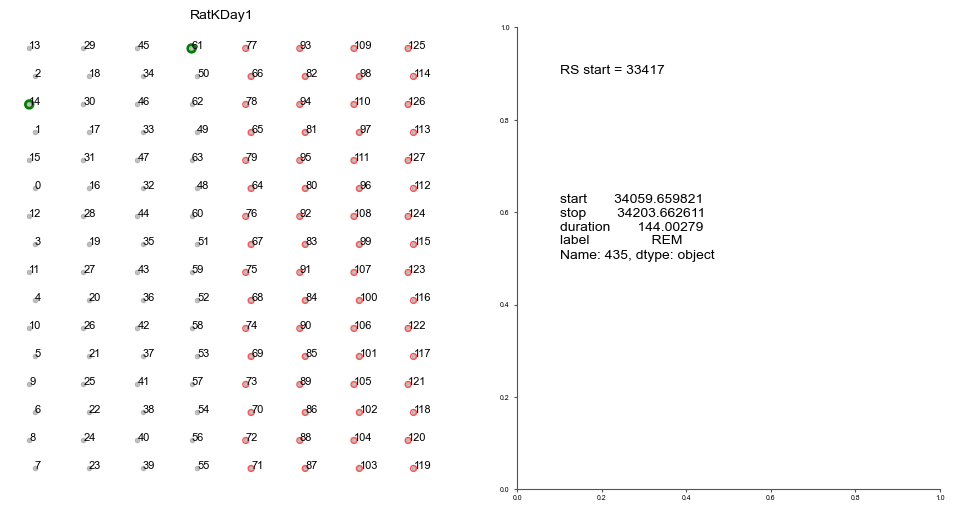

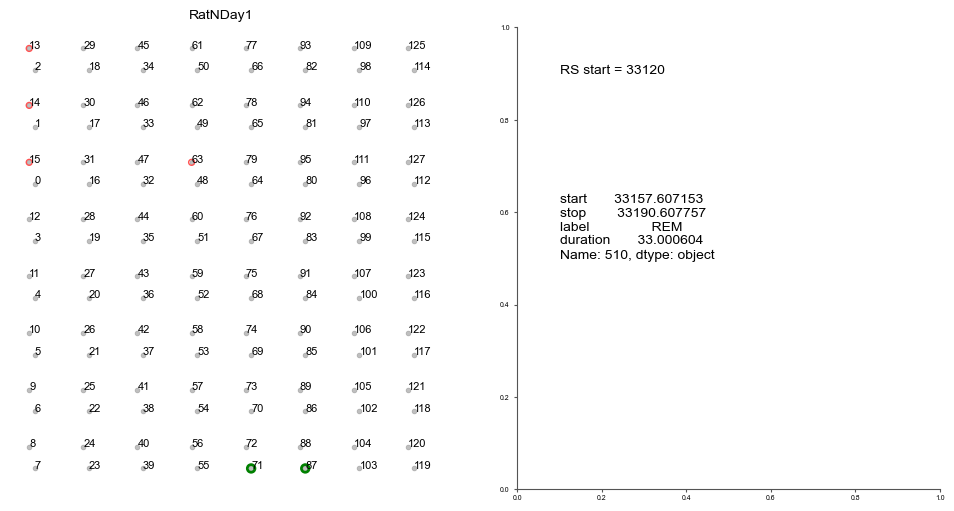

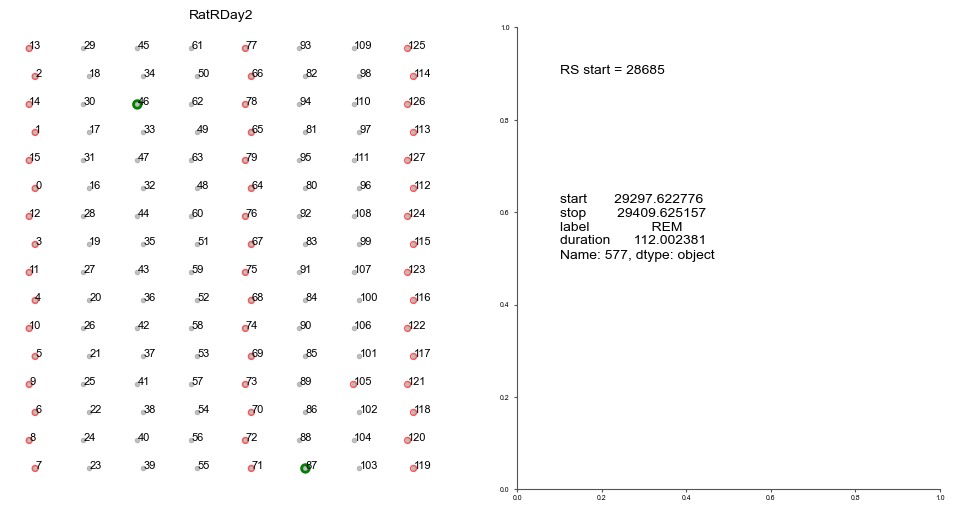

In [4]:
# First, visualize channels being uses for plotting.
from neuropy.plotting.probe import plot_probe
for sess in sessions:
    _, ax = plt.subplots(1, 2, figsize=(12, 6))
    plot_probe(sess.probegroup, annotate_channels=[sess.best_channels.theta, sess.best_channels.slow_wave], ax=ax[0])
    ax[0].set_title(sess.name, fontsize=10)

    bs_df = sess.brainstates.to_dataframe()
    rem_df = bs_df[bs_df.label == "REM"]
    rs_start = sess.paradigm['post'].flatten()[0] + 3600 * 5
    rs_rem_df = rem_df[rem_df.start > rs_start]
    ax[1].text(0.1, 0.9, f"RS start = {rs_start}")
    ax[1].text(0.1, 0.5, rs_rem_df.iloc[0,:])


In [5]:
from neuropy.utils.signal_process import filter_sig, FourierSg
from scipy.ndimage import gaussian_filter1d
from neuropy.core import Epoch
from neuropy.utils.signal_process import irasa, whiten
from copy import deepcopy

# sessions = subjects.sd.ripple_sess
sessions = subjects.sd.ratKday1 + subjects.sd.ratNday1 + subjects.sd.ratRday2

whiten_spect_list: list[FourierSg] = []
states_list: list[Epoch] = []
for s, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    nrem = (
        sess.brainstates["NREM"].time_slice(post[0], post[1]).duration_slice(min_dur=120)
    )
    nrem_onset = nrem.flatten()[0] - 1000

    # period = [nrem_onset, nrem_onset + 3600]
    period = [post[0] + 5 * 3600, post[0] + 6 * 3600]
    chan = sess.best_channels.slow_wave
    lfp = sess.eegfile.get_signal(chan, *period)
    srate = sess.eegfile.sampling_rate

    freqs, psd_aperiodic, psd_osc, fit_df = irasa(lfp.traces.squeeze().astype(float), srate, band=(1, 100), return_fit=True)
    psd_interp = lambda x: np.interp(x, freqs, psd_aperiodic.squeeze())
    traces_whiten = whiten(lfp.traces.squeeze(), psd_interp, 1/lfp.sampling_rate)
    lfp_whiten = deepcopy(lfp)
    lfp_whiten.traces = traces_whiten[None, :]

    spect_whiten = FourierSg(lfp_whiten, window=4, overlap=1).freq_slice(1, 10)
    states = sess.brainstates.time_slice(period[0], period[1])

    whiten_spect_list.append(spect_whiten)
    states_list.append(states)

    # swa = spect.freq_slice(0.5, 4).traces.sum(axis=0)
    # spect_srate = spect.sampling_rate
    # swa = gaussian_filter1d(swa, sigma=4 * spect_srate)
    # swa = stats.zscore(swa)
    # time = spect.time - post[0]

    # df = pd.DataFrame(dict(time=time / 3600, swa=swa, session=s, grp=sess.tag))
    # swa_df.append(df)

# swa_df = pd.concat(swa_df, ignore_index=True)

(1, 2501) [[1.88558549e+03 1.41039988e+04 2.69616528e+04 ... 3.83658498e-02
  3.87680079e-02 1.59327773e-02]]
(1, 2501) [[1.11023499e+03 8.05319063e+03 1.93830167e+04 ... 5.53483531e-02
  5.52174469e-02 2.29667801e-02]]
(1, 2501) [[2.60011157e+02 1.46795161e+03 3.23980328e+03 ... 4.87714577e-02
  4.86089430e-02 1.92794471e-02]]


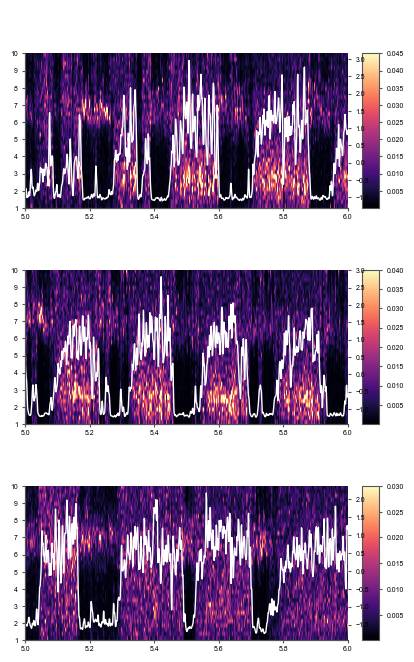

In [12]:
fig = subjects.SdFig().fig_supp(height_ratios=[1, 6, 1, 6, 1, 6, 1, 6],
                                width_ratios = [1, 1, 1, 1, 0.25, 0.75, 1.5, 1.5])

for i, vmax in zip(range(len(sessions)), (0.045, 0.04, 0.03)):
    ax = fig.subplot(fig.gs[i * 2 + 1, :4])
    cax = fig.subplot(fig.gs[i * 2 + 1, 4])
    sxx = whiten_spect_list[i]

    swa = sxx.freq_slice(1, 4).traces.sum(axis=0)
    spect_srate = sxx.sampling_rate
    swa = gaussian_filter1d(swa, sigma=4 * sxx.sampling_rate)
    swa = stats.zscore(swa)
    time = (sxx.time - sxx.time[0]) / 3600 + 5

    splot = ax.imshow(
        sxx.traces,
        aspect="auto",
        origin="lower",
        extent=[5, 6, 1, 10],
        cmap="magma",
        vmax=vmax,
    )
    # splot2 = axdup.imshow(
    #     sxx.traces,
    #     aspect="auto",
    #     origin="lower",
    #     extent=[5, 6, 1, 10],
    #     cmap="magma",
    #     vmax=vmax,
    # )
    plt.colorbar(splot, cax=cax)
    ax2 = ax.twinx()
    ax2.plot(time, swa, color="w", lw=1)

    post = sessions[i].paradigm["post"].flatten()
    period = [post[0] + 5 * 3600, post[0] + 6 * 3600]

    ax3 = fig.subplot(fig.gs[i * 2, :4])
    states = sessions[i].brainstates

    # Combined QW/AW Code
    # wk_states = states.label_slice(["AW", "QW"]).set_labels("WK").merge_neighbors()
    # slp_states = states.label_slice(["NREM", "REM"])
    # all_states = slp_states + wk_states

    # Split QW/AW code
    # Change resolution
    if state_bin_size > 1/60/60:
        # states = states.resample_labeled_epochs(state_bin_size, t_start=time[0], t_stop=time[-1], merge_neighbors=True)
        states = states.resample_labeled_epochs(state_bin_size, t_start=5, t_stop=6, merge_neighbors=True)
        bin_append = f"_statebin{state_bin_size}"
        
    if combine_wake: # Combine wake states
        wk_states = states.label_slice(["AW", "QW"]).set_labels("WK").merge_neighbors()
        labels_order = ["NREM", "REM", "WK"]
    else: # Keep states split
        wk_states = states.label_slice(["AW", "QW"])
        labels_order = ["NREM", "REM", "QW", "AW"]
    slp_states = states.label_slice(["NREM", "REM"])
    all_states = slp_states + wk_states
    plotting.plot_epochs(
        epochs=all_states, ax=ax3, labels_order=labels_order, colors="k"
    )
    ax3.set_xlim(period)
    ax3.set_axis_off()
fig.savefig(subjects.figpath_sd / "sd_slow_oscillation_recovery_sleep_whitened_vmax_varies", format="svg")

### THIS METHOD USED FOR EDF2A! Same as above but using theta channel
Note that for RatNDay1 (session 2) I hand-picked the channel with high theta.

In [69]:
from neuropy.utils.signal_process import filter_sig, FourierSg
from scipy.ndimage import gaussian_filter1d
from neuropy.core import Epoch, Signal
from neuropy.utils.signal_process import irasa, whiten
from copy import deepcopy

# sessions = subjects.sd.ripple_sess
sessions = subjects.sd.ratVday2 + subjects.sd.ratNday1 + subjects.sd.ratRday2
start_time, end_time = 4.9, 6.0

whiten_spect_list: list[FourierSg] = []
states_list: list[Epoch] = []
emg_list: list[Signal] = []
for s, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    nrem = (
        sess.brainstates["NREM"].time_slice(post[0], post[1]).duration_slice(min_dur=120)
    )
    nrem_onset = nrem.flatten()[0] - 1000

    # period = [nrem_onset, nrem_onset + 3600]
    period = [post[0] + start_time * 3600, post[0] + end_time * 3600] 
    chan = sess.best_channels.theta if s != 1 else 42  # Manually adjust to channel with high theta power for RatNDay1
    print(chan)
    lfp = sess.eegfile.get_signal(chan, *period)
    srate = sess.eegfile.sampling_rate

    freqs, psd_aperiodic, psd_osc, fit_df = irasa(lfp.traces.squeeze().astype(float), srate, band=(1, 100), return_fit=True)
    psd_interp = lambda x: np.interp(x, freqs, psd_aperiodic.squeeze())
    traces_whiten = whiten(lfp.traces.squeeze(), psd_interp, 1/lfp.sampling_rate)
    lfp_whiten = deepcopy(lfp)
    lfp_whiten.traces = traces_whiten[None, :]

    spect_whiten = FourierSg(lfp_whiten, window=4, overlap=1).freq_slice(1, 10)
    states = sess.brainstates.time_slice(period[0], period[1])

    whiten_spect_list.append(spect_whiten)
    states_list.append(states)

    emg_list.append(sess.emg)

    # swa = spect.freq_slice(0.5, 4).traces.sum(axis=0)
    # spect_srate = spect.sampling_rate
    # swa = gaussian_filter1d(swa, sigma=4 * spect_srate)
    # swa = stats.zscore(swa)
    # time = spect.time - post[0]

    # df = pd.DataFrame(dict(time=time / 3600, swa=swa, session=s, grp=sess.tag))
    # swa_df.append(df)

# swa_df = pd.concat(swa_df, ignore_index=True)

30
(1, 2501) [[1.17642495e+03 7.97187401e+03 1.87514310e+04 ... 4.93186559e-02
  5.06193321e-02 2.03054145e-02]]
42
(1, 2501) [[1.51312790e+03 1.06654426e+04 2.68158846e+04 ... 5.96151303e-02
  6.02344751e-02 2.65732822e-02]]
46
(1, 2501) [[3.03056715e+02 1.98153473e+03 3.82499552e+03 ... 4.26610653e-02
  4.27566923e-02 1.73720107e-02]]


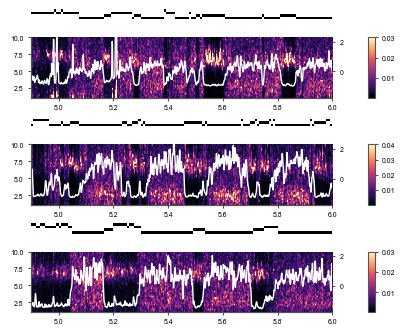

In [71]:
fig = subjects.SdFig().fig_supp(height_ratios=[1, 6, 1, 6, 1, 6, 25, 25],
                                width_ratios = [1, 1, 1, 0.7, 0.1, 0.1, 2.05, 2.05])

combine_wake = False  # Split AW and QW (False) or combine into WAKE (True)
state_bin_size = 30  # seconds

for i, vmax in zip(range(len(sessions)), (0.03, 0.04, 0.03)):
    ax = fig.subplot(fig.gs[i * 2 + 1, :4])
    cax = fig.subplot(fig.gs[i * 2 + 1, 5])
    sxx = whiten_spect_list[i]

    # Plot spectrogram
    splot = ax.imshow(
        sxx.traces,
        aspect="auto",
        origin="lower",
        extent=[start_time, end_time, 1, 10],
        cmap="magma",
        vmax=vmax,
    )
    # splot2 = axdup.imshow(
    #     sxx.traces,
    #     aspect="auto",
    #     origin="lower",
    #     extent=[5, 6, 1, 10],
    #     cmap="magma",
    #     vmax=vmax,
    # )
    plt.colorbar(splot, cax=cax)

    # Plot SWA as a white line
    swa = sxx.freq_slice(1, 4).traces.sum(axis=0)
    spect_srate = sxx.sampling_rate
    swa = gaussian_filter1d(swa, sigma=4 * sxx.sampling_rate)
    swa = stats.zscore(swa)
    time = (sxx.time - sxx.time[0]) / 3600 + start_time
    ax2 = ax.twinx()
    ax2.plot(time, swa, color="w", lw=1)
    ax2.set_ylim((-1.8, 2.3))

    # Plot EMG as a green line
    # 
    # emg = emg_list[i]
    # emg = emg.time_slice(t_start=period[0], t_stop=period[1])
    # emg_time = (emg.time - emg.time[0]) / 3600 + start_time
    # ax2.plot(emg_time, emg.traces.squeeze()*2, 'g--', linewidth=0.5)
    
    # Plot hypnogram
    post = sessions[i].paradigm["post"].flatten()
    period = [post[0] + start_time * 3600, post[0] + end_time * 3600]
    ax3 = fig.subplot(fig.gs[i * 2, :4])
    states = sessions[i].brainstates
    # Combined QW/AW code
    # wk_states = states.label_slice(["AW", "QW"]).set_labels("WK").merge_neighbors()
    # slp_states = states.label_slice(["NREM", "REM"])
    # all_states = slp_states + wk_states

    # Split QW/AW code
    # Change resolution
    if state_bin_size > 1:
        # states = states.resample_labeled_epochs(state_bin_size, t_start=time[0], t_stop=time[-1], merge_neighbors=True)
        states = states.resample_labeled_epochs(state_bin_size, t_start=period[0], t_stop=period[-1], merge_neighbors=True)
        bin_append = f"_statebin{state_bin_size}"
        
    if combine_wake: # Combine wake states
        wk_states = states.label_slice(["AW", "QW"]).set_labels("WK").merge_neighbors()
        labels_order = ["NREM", "REM", "WK"]
    else: # Keep states split
        wk_states = states.label_slice(["AW", "QW"])
        labels_order = ["NREM", "REM", "QW", "AW"]
    slp_states = states.label_slice(["NREM", "REM"])
    all_states = slp_states + wk_states
    plotting.plot_epochs(
        epochs=all_states, ax=ax3, labels_order=labels_order, colors="k"
    )
    ax3.set_xlim(period)
    ax3.set_axis_off()
fig.savefig(subjects.figpath_sd / "sd_slow_oscillation_recovery_sleep_theta_whitened_vmax_varies", format="svg")